In [18]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [25]:
import GPy, GPyOpt

import pandas as pd
import numpy as np

from src import models
from src import experimental_setup

# Experimental setup

In [26]:
encoding = 'mordred'

kfold = experimental_setup.CrossValidator(
    splits = 5,
    sampling_type = 'random',
)

# Define search region

bounds = [
    {'name': "n_estimators", 'type': 'discrete', 'domain': [32,64,128,256,512,1024,2048,4096]},
    {'name': "max_depth", 'type': 'discrete',   'domain': [8,16,32,64]},
    {'name': 'min_samples_split', 'type': 'discrete', 'domain': [2,4,8,16,32]},
    {'name': 'min_samples_leaf', 'type': 'discrete', 'domain': [1,2,4,8,16]}
]

# Optimization candidate

In [29]:
from sklearn.metrics import mean_absolute_error

def search(x):
    def create_model():
        model = models.RF()
        
        model.n_estimators = int(x[:,0])
        model.max_depth = int(x[:,1])
        model.min_samples_split = int(x[:,2])
        model.min_samples_leaf = int(x[:,3])
        
        return model
    
    errors = []
    
    for fold_no, (train, test) in enumerate(kfold.get_folds(encoding)):
        x_train, y_train, smiles_train = train
        x_test, y_test, smiles_test = test
        
        y_train = experimental_setup.scaler.fit_transform(y_train)
        
        model = create_model()
        model.fit(x_train.astype(np.float32), y_train)
        
        y_hat = experimental_setup.scaler.inverse_transform(model.predict(x_test))
        
        errors.append( mean_absolute_error(y_test.flatten(), y_hat.flatten()) )
    
    print(np.mean(errors))
    return np.mean(errors)

# Tune

In [30]:
print("Begin processing!")

optimizer = GPyOpt.methods.BayesianOptimization(f=search, domain=bounds,
                model_type='GP',
                acquisition_type ='EI',
                acquisition_jitter = 0.05,
                exact_feval = True,
                num_cores = 40, # Adjust 
                maximize = False,
                verbosity = True)

print("Starting Optimizer!")
optimizer.run_optimization(max_iter=40)

print("Finished Optimization!")

Begin processing!
0.3797249792333163
0.39319387858288046
0.4663533976090483
0.46614197713465144
0.4195056001220892
Starting Optimizer!
0.39319387858288046
0.37741085185538764
0.3726722411947542
0.37144999452809213
0.3714586293517447
0.4052331551621669
0.41214076070152056
0.4661945562247164
0.46485073215333833
0.4234007325726245
0.4654706009384605
0.39662668783772653
0.37144999452809213
0.37144999452809213
Finished Optimization!


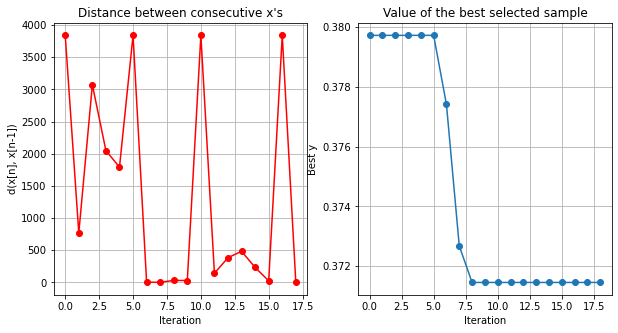

In [32]:
optimizer.plot_convergence()

In [ ]:
('n_estimators', optimizer.x_opt[0]),\
    ('max_depth', optimizer.x_opt[1]),\
    ('min_samples_split', optimizer.x_opt[2]),\
    ('batch_size', optimizer.x_opt[3])

In [41]:
[(bounds[i]['name'], optimum) for i, optimum in enumerate(optimizer.x_opt)]

[('n_estimators', 4096.0),
 ('max_depth', 32.0),
 ('min_samples_split', 2.0),
 ('min_samples_leaf', 1.0)]